In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import astropy.table as at
import astropy.units as u
from utils import *
import pickle

/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/state/profiles/x86_64/rocky8/jupyter-2.3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.sm

In [2]:
data = at.QTable.read("clean-actions-for-teresa.fits")
print(data["J"].shape)  # actions in order: J_R, J_phi, J_z
print(data["theta"].shape)  # angles in same order
print(data["xyz"].shape)  # cartesian positions: x, y, z
print(data["vxyz"].shape)  # cartesian velocity

(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)


In [3]:
a = np.random.rand(2)
np.sqrt(a)

array([0.8500096 , 0.77453142])

In [4]:
def np_mask_out_nan(data, i, save=True, home_path='.', seed=0):  
  xyz = data["xyz"][:,i].to_value()
  vxyz = data["vxyz"][:,i].to_value()
  J = data["J"][:,i].to_value()
  angle = data["theta"][:,i].value
  mask_x = np.isnan(xyz)
  mask_v = np.isnan(vxyz)
  mask_J = np.isnan(J)
  mask_omega = np.isnan(angle)
  combined_mask = mask_x | mask_v | mask_J | mask_omega
  if save:
    data_dict = {"dim": i}
    data_dict['X'] = xyz[~combined_mask] #y-axis
    data_dict['V'] = vxyz[~combined_mask] #x-axis
    data_dict['J'] = J[~combined_mask]
    data_dict['omega'] = angle[~combined_mask]
    data_dict['X_o'] = np.sqrt(2*data_dict['J'] ) * np.sin(data_dict['omega'])
    data_dict['V_o'] = np.sqrt(2*data_dict['J'] ) * np.cos(data_dict['omega'])
    num_samples = data_dict['X'].shape[0]
    train_indices, val_indices, test_indices = generate_split(num_samples, random_seed=seed)

    data_dict['splits'] = (train_indices, val_indices, test_indices)
    pickle.dump(data_dict, open(f"{home_path}/clean_data_1D_dim={i}.pkl", "wb"))

  return xyz[~combined_mask], vxyz[~combined_mask], J[~combined_mask], angle[~combined_mask]
  #return combined_mask


In [5]:
xyz, vxyz, J, angle = np_mask_out_nan(data, 2)

In [6]:
xyz.shape

(100000,)

In [7]:
def np_to_volume_preserving_standard(X):
    '''
    '''
    N, twod = X.shape
    d = twod // 2
    assert d * 2 == twod
    std = X.std(axis=0) # probably should be based on percentiles not std
    tau = std[:d] / std[d:] # units of time; BRITTLE: assumes xs before vs
    offsets = np.zeros(twod) # HACK: hard code zero offsets
    scales = np.zeros(twod)
    scales[:d] = np.sqrt(tau) # BRITTLE: see above
    scales[d:] = 1. / scales[:d] # ensures volume preservation
    return (X - offsets) / scales, offsets, scales

In [14]:
def plot_pred(x_pred, v_pred, Q, title, ax,
              xlabel=r"$\sqrt{J_z} \cos(\theta_z)$", ylabel=r"$\sqrt{J_z} \sin(\theta_z)$",
              swap=True, max=2, circle_refs=True):
    stat_Jth = binned_statistic_2d(x_pred,v_pred,Q,bins=np.linspace(-max, max, 128))
    ax.pcolormesh(
        stat_Jth.x_edge,
        stat_Jth.y_edge,
        stat_Jth.statistic.T,
        vmin=0, vmax=0.4
    )
    if circle_refs:
        for r in max*np.array([1/10, 1/5,2/5,3/5,4/5]): #np.array([2, 4, 6, 8, 10]):
            ax.add_patch(plt.Circle((0, 0), r, facecolor="none", edgecolor="tab:blue", lw=1.5, alpha=0.5))
    if swap:
        ax.set(xlabel=ylabel, ylabel=xlabel)
    else:
        ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(title)
    ax.axis('equal')

In [9]:
xv = np.stack((xyz, vxyz), axis=-1)
xv_norm, mean, std = np_to_volume_preserving_standard(xv)

In [10]:
xv_norm.shape

(100000, 2)

In [11]:
Q = np.sqrt(2*J)
Q.shape

(100000,)

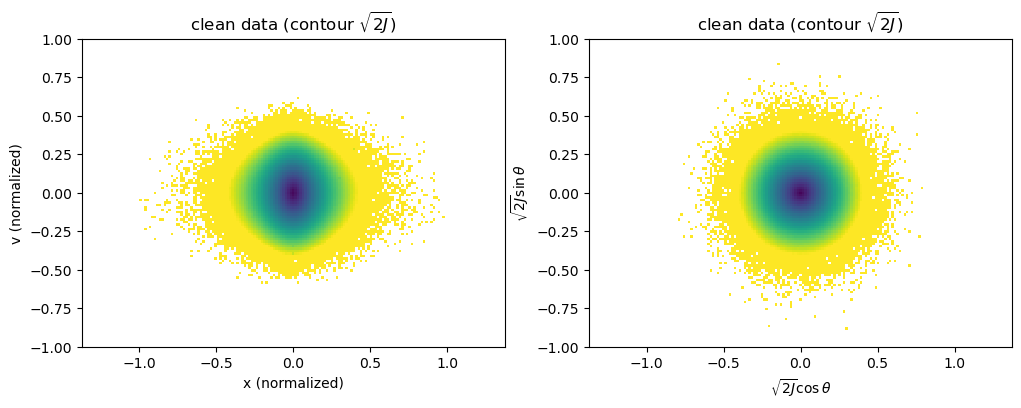

In [96]:
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(12,4))
title1 = r'clean data (contour $\sqrt{2J}$)'
plot_pred(xv_norm[:,0], xv_norm[:,1], Q, title1, axs[0], swap=False, circle_refs=False, max=1,
           xlabel='x (normalized)', ylabel='v (normalized)',)

rootJsin = np.sqrt(2*J) * np.sin(angle)
rootJcos = np.sqrt(2*J) * np.cos(angle)
plot_pred( rootJcos,rootJsin, Q, title1, axs[1], swap=False, circle_refs=False, max=1,
          ylabel=r'$\sqrt{2J} \sin \theta$', xlabel=r'$\sqrt{2J} \cos \theta$')

### Load models and results

In [2]:
def load_data(file_path, data_path, swap=True, standardize=True, train=False):
    #obtain eval set prediction 
    save_file = pickle.load(open(file_path,"rb"))  
    #input_max = save_file['input_max']
    x_pred = save_file['x_pred']
    v_pred = save_file['v_pred']
    mean_in, std_in =  save_file['input_mean_std']
    mean_out, std_out = save_file['output_mean_std']
    xv_pred = torch.concatenate((x_pred,v_pred), axis=-1)
    if standardize == False:
        xv_pred = from_standard(xv_pred, mean_out, std_out)
    #xv_pred = from_standard(torch.concatenate((x_pred,v_pred), axis=-1), mean, std)
    data_dict =  pickle.load(open(data_path, "rb"))
    train_indices, val_indices, test_indices = data_dict['splits']
    if train:
        indices = train_indices
    else:
        indices = val_indices
    
    J = data_dict['J']
    Q = np.sqrt(2*J)[indices]
    
    X_o = data_dict['X_o'][indices]
    V_o = data_dict['V_o'][indices]
    xv_out = torch.from_numpy(np.stack((X_o, V_o), axis=-1)).float()
    X = data_dict['X'][indices]
    V = data_dict['V'][indices]
    xv = torch.from_numpy(np.stack((X, V), axis=-1)).float()
    if standardize:
        xv = (xv - mean_in)/std_in 
        #xv /= input_max
        #xv_out = (xv_out - mean_out)/std_out
        #xv_out /= input_max
    #eturn xv_pred, X_o, V_o, X, V, Q, save_file['train_loss']
    return xv_pred, xv_out, xv, Q, save_file['train_loss']

In [36]:
lr = 0.01
ep = 100
num_layers = 4
hid_dim = 4
epsilon = 1.0
relMSE = False
tie = False
weighted = True #
wscale = 5.0 #1.0
tratio = 0.4
#dir_path = f"results_clean/_layer={num_layers}_hid={hid_dim}_lr={lr}_tie={tie}_ep={ep}_epsilon={epsilon}_relMSE={relMSE}/"
dir_path = f"results_clean/_layer={num_layers}_hid={hid_dim}_lr={lr}_tie={tie}_ep={ep}_epsilon={epsilon}_weightMSE={weighted}_wscale={wscale}_tratio={tratio}/"

file_path = f"{dir_path}save_file.pkl"
data_path = "clean_data_1D_dim=2.pkl"
#xv_pred, X_o, V_o, X, V, Q, train_loss = load_data(file_path, data_path)
xv_pred, xv_out, xv, Q_val, train_loss = load_data(file_path, data_path, train=False)


In [37]:
def plot_points(xv, xv_out, xv_pred, Q_val, fig_title=None):
    fig, axs = plt.subplots(ncols=3, dpi=100, figsize=(12,4))
    title1 = r'clean input (contour $\sqrt{2J}$)'
    plot_pred(xv[:,0], xv[:,1], Q_val, title1, axs[0], swap=False, circle_refs=False, max=1,
            xlabel='$x$ (normalized)', ylabel='$v$ (normalized)',)

    title2 = r'prediction  (contour $\sqrt{2J}$)'
    plot_pred(xv_pred[:,0], xv_pred[:,1], Q_val, title2, axs[1], swap=False, circle_refs=False, max=1,
            xlabel=r'$\hat{x}_o$ (normalized)', ylabel=r'$\hat{v}_o$ (normalized)',)

    title3 = r'clean output (contour $\sqrt{2J}$)'

    plot_pred(xv_out[:,0], xv_out[:,1], Q_val, title3, axs[2], swap=False, circle_refs=False, max=1,
            ylabel=r'$v_o = \sqrt{2J} \sin \theta$', xlabel=r'$x_o = \sqrt{2J} \cos \theta$')
    if fig_title is not None:
        fig.suptitle(fig_title, y=0.95)
    fig.tight_layout()
    plt.show()

def plot_input_output(XV, XV_out, pred_XV_out, untrain_XV_out=None, fig_title=None):
    assert XV.shape == XV_out.shape == pred_XV_out.shape
    fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
    for i in range(2):
        axs[i].scatter(XV[:,i], XV_out[:,i], label='target', color='tab:blue', alpha=0.7)
        axs[i].scatter(XV[:,i], pred_XV_out[:,i], label='prediction', color='tab:orange', alpha=0.7)
        if untrain_XV_out is not None:
            axs[i].scatter(XV[:,i], untrain_XV_out[:,i], label='prediction (untrain)', color='tab:gray', alpha=0.7)

    axs[0].set_title('position', fontsize=15)
    axs[1].set_title('velocity', fontsize=15)
    for ax in axs:
        ax.axline((0, 0), slope=1, color='gray', ls='--') #reference y=x
        ax.set_xlabel('input', fontsize=15)
        ax.set_ylabel('target', fontsize=15)
        ax.legend(fontsize=15, loc='upper left')
    if fig_title is not None:
        fig.suptitle(fig_title, y=0.95)
    fig.tight_layout()
    plt.show()

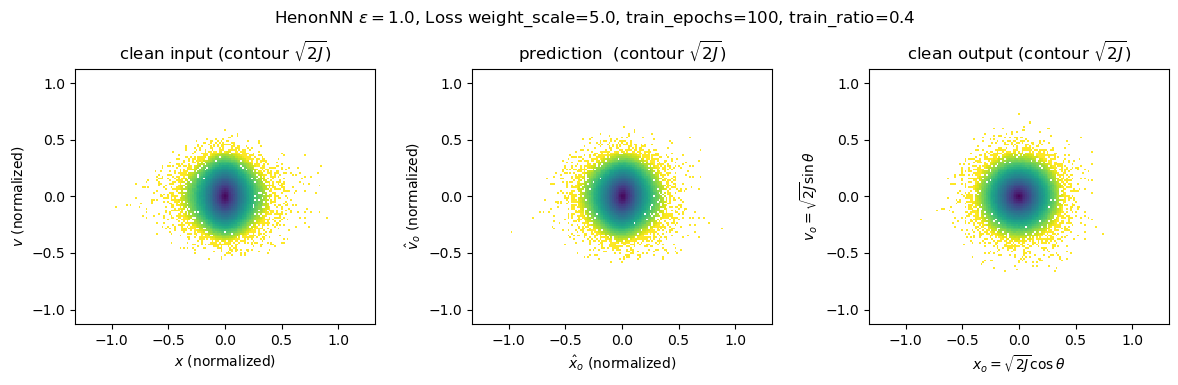

In [38]:
wscale = 'NA' if weighted==False else wscale
title_eps1 = r'HenonNN $\epsilon=$'+f'{epsilon}, Loss weight_scale={wscale}, train_epochs={ep}, train_ratio={tratio}'
plot_points(xv, xv_out, xv_pred, Q_val, fig_title=title_eps1)

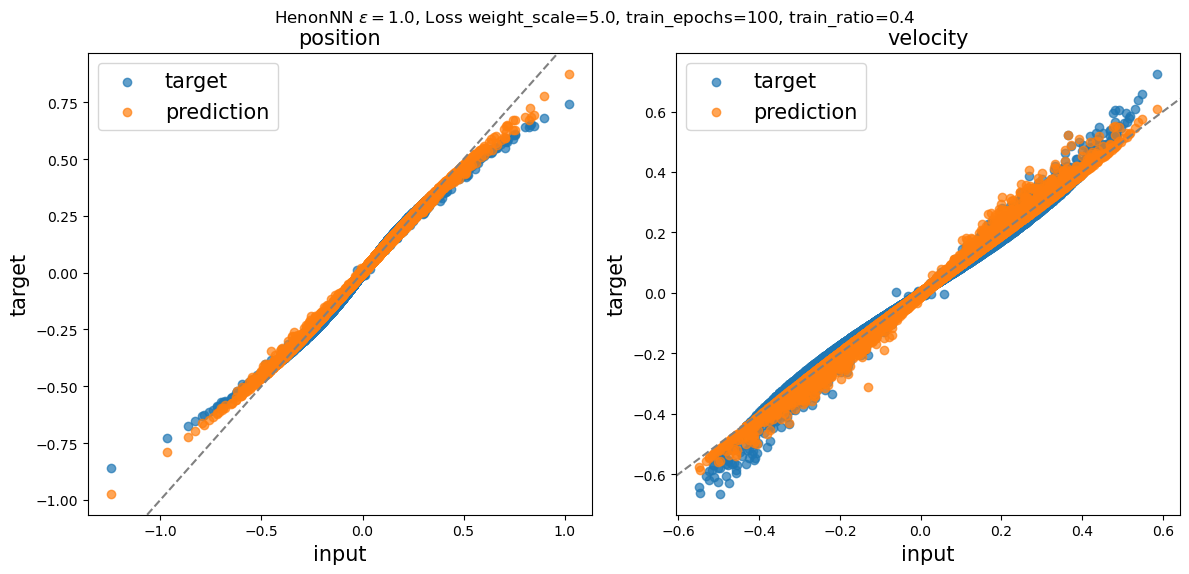

In [39]:
plot_input_output(xv, xv_out, xv_pred, fig_title=title_eps1)

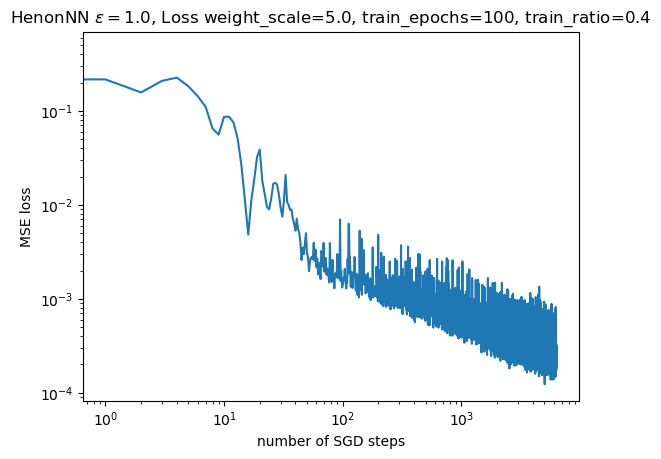

In [40]:
plt.plot(train_loss)
plt.xlabel('number of SGD steps')
plt.ylabel('MSE loss')
plt.loglog()
plt.title(title_eps1)
plt.show()